# Graphics using Seaborn

We previously have covered how to do some basic graphics using `matplotlib`. In this notebook we introduce a package called `seaborn`. `seaborn` builds on top of `matplotlib` by doing 2 things:

1. Gives us access to more types of plots (Note: Every plot created in `seaborn` could be made by `matplotlib`, but you shouldn't have to worry about doing this)
2. Sets better defaults for how the plot looks right away

Before we start, make sure that you have `seaborn` installed. If not, then you can install it by

```
conda install seaborn
```

_This notebook was created by Dave Backus, Chase Coleman, and Spencer Lyon for the NYU Stern course [Data Bootcamp](http://databootcamp.nyuecon.com/)._

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys

%matplotlib inline

As per usual, we begin by listing the versions of each package that is used in this notebook.

In [2]:
# check versions (overkill, but why not?)
print('Python version:', sys.version)
print('Pandas version: ', pd.__version__)
print('Matplotlib version: ', mpl.__version__)
print('Seaborn version: ', sns.__version__)

Python version: 3.5.1 |Anaconda 4.0.0 (64-bit)| (default, Feb 16 2016, 09:49:46) [MSC v.1900 64 bit (AMD64)]
Pandas version:  0.18.0
Matplotlib version:  1.5.1
Seaborn version:  0.7.0


## Datasets

There are some classical datasets that get used to demonstrate different types of plots. We will use several of them here.

* tips : This dataset has informaiton on waiter tips. Includes information such as total amount of the bill, tip amount, sex of waiter, what day of the week, which meal, and party size.
* anscombe: This dataset is a contrived example. It has 4 examples which differ drastically when you look at them, but they have the same correlation, regression coefficient, and $R^2$.
* titanic : This dataset has information on each of the passengers who were on the titanic. Includes information such as: sex, age, ticket class, fare paid, whether they were alone, and more.

In [3]:
tips = sns.load_dataset("tips")
ansc = sns.load_dataset("anscombe")
tita = sns.load_dataset("titanic")

# Better Defaults

Recall that in our [previous notebook](bootcamp_graphics.ipynb) that we used `plt.style.use` to set styles. We will begin by setting the style to `"classic"`; this sets all of our default settings back to `matplotlib`'s default values.

Below we plot open and closing prices on the top axis and the implied returns on the bottom axis.

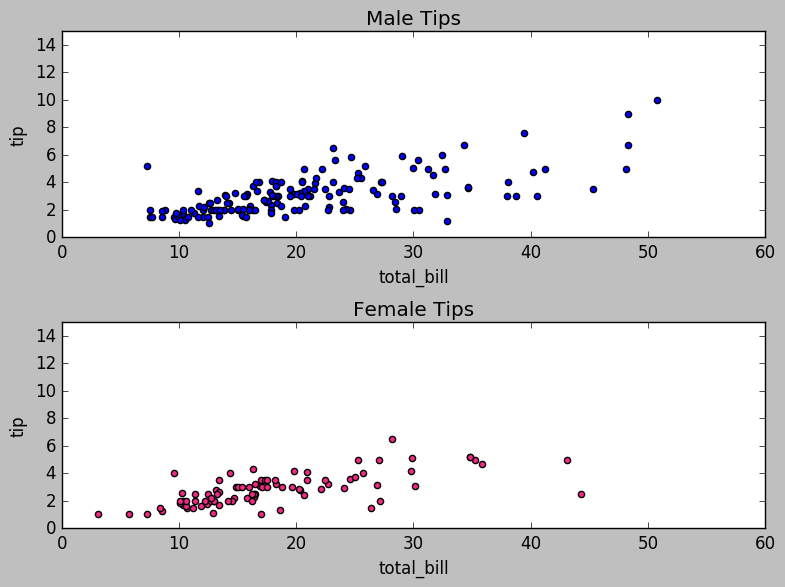

In [28]:
plt.style.use("classic")

def plot_tips():
    fig, ax = plt.subplots(2, figsize=(8, 6))

    tips[tips["sex"] == "Male"].plot(x="total_bill", y="tip", ax=ax[0], kind="scatter",
                                     color="blue")
    tips[tips["sex"] == "Female"].plot(x="total_bill", y="tip", ax=ax[1], kind="scatter",
                                       color="#F52887")

    ax[0].set_xlim(0, 60)
    ax[1].set_xlim(0, 60)
    ax[0].set_ylim(0, 15)
    ax[1].set_ylim(0, 15)

    ax[0].set_title("Male Tips")
    ax[1].set_title("Female Tips")

    fig.tight_layout()

plot_tips()
# fig.savefig("/home/chase/Desktop/foo.png")

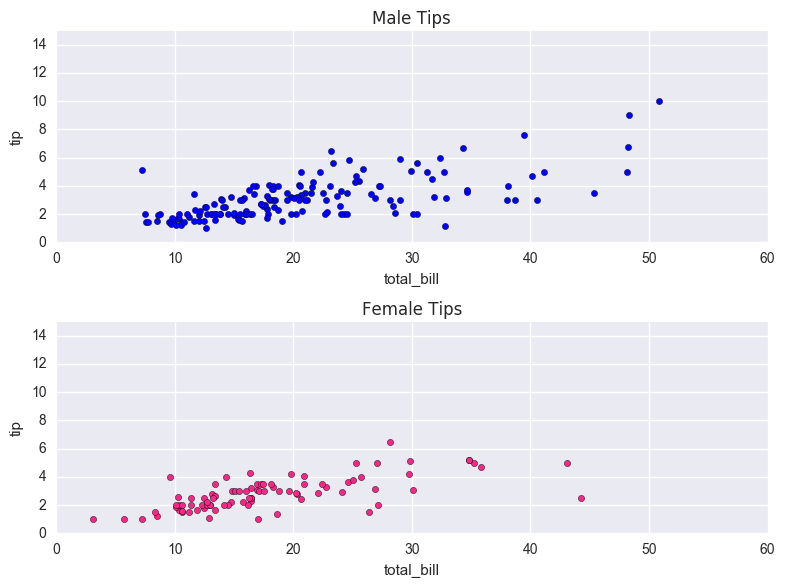

In [29]:
# sns.set() resets default seaborn settings
sns.set()

plot_tips()

What did you notice about the differences in the settings of the plot?

Which do you like better? We like the second better.

Investigate other styles and create the same plot as above using a style you like. You can choose from the list in the code below.

If you have additional time, visit the [seaborn docs](http://stanford.edu/~mwaskom/software/seaborn/tutorial/aesthetics.html#temporarily-setting-figure-style) and try changing other default settings.

In [8]:
plt.style.available

['dark_background',
 'seaborn-talk',
 'seaborn-whitegrid',
 'seaborn-white',
 'seaborn-muted',
 'seaborn-pastel',
 'ggplot',
 'seaborn-bright',
 'fivethirtyeight',
 'grayscale',
 'classic',
 'seaborn-dark',
 'seaborn-ticks',
 'seaborn-paper',
 'seaborn-notebook',
 'seaborn-deep',
 'seaborn-darkgrid',
 'seaborn-poster',
 'seaborn-colorblind',
 'seaborn-dark-palette',
 'bmh']

We could do the same for a different style (like `ggplot`)

In [24]:
sns.axes_style?

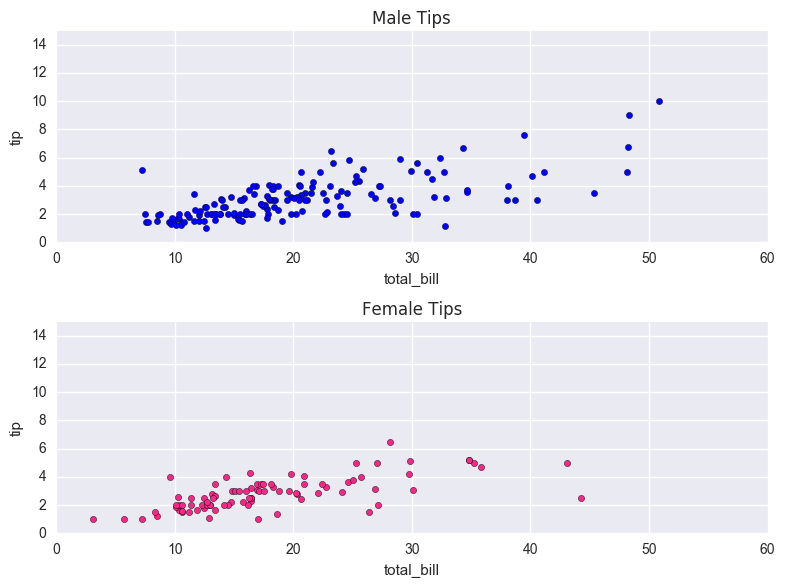

In [26]:
sns.set()

plot_tips()

**Exercise**: Find a style you like and recreate the plot above using that style.

# The Juicy Stuff

While having `seaborn` set sensible defaults is convenient, it isn't a particularly large innovation. We could choose sensible defaults and set them to be our default. The main benefit of `seaborn` is the types of graphs that it gives you access to -- All of which could be done in `matplotlib`, but, instead of 5 lines of code, it would require possibly hundreds of lines of code. Trust us... This is a good thing.

We don't have time to cover everything that can be done in `seaborn`, but we suggest having a look at the [gallery](http://stanford.edu/~mwaskom/software/seaborn/examples/index.html) of examples.

We will cover:

* `kdeplot`
* `jointplot`
* `violinplot`
* `pairplot`
* ...

In [ ]:
# Move back to seaborn defaults
sns.set()

## kdeplot

What does kde stand for?

kde stands for "kernel density estimation." This is (far far far) beyond the scope of this class, but the basic idea is that this is a smoothed histogram. When we are trying to get information about distributions it sometimes looks nicer than a histogram does.

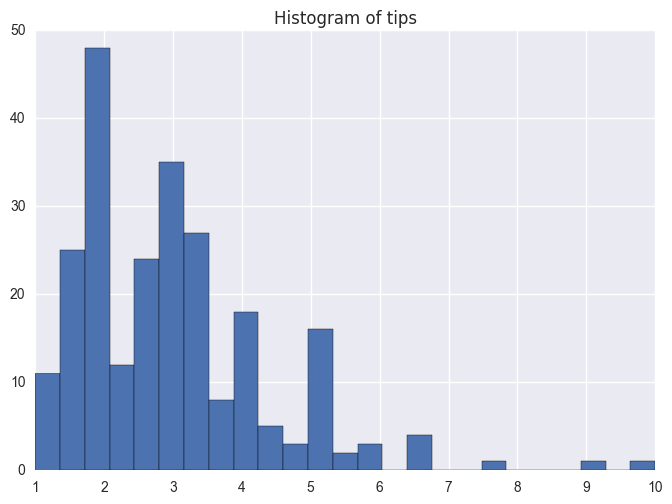

In [30]:
fig, ax = plt.subplots()

ax.hist(tips["tip"], bins=25)

ax.set_title("Histogram of tips")
plt.show()


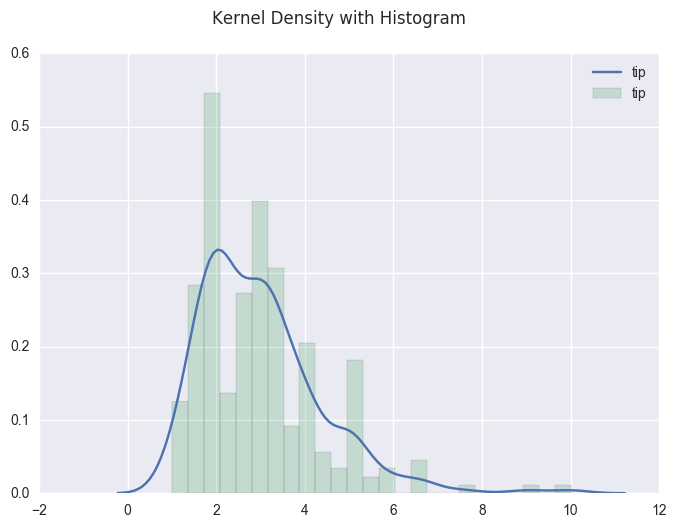

In [33]:
fig, ax = plt.subplots()

sns.kdeplot(tips["tip"], ax=ax)
ax.hist(tips["tip"], bins=25, alpha=0.25, normed=True, label="tip")
ax.legend()

fig.suptitle("Kernel Density with Histogram");

**Exercise**: Create your own kernel density plot using `sns.kdeplot` of `"total_bill"` from the `tips` dataframe

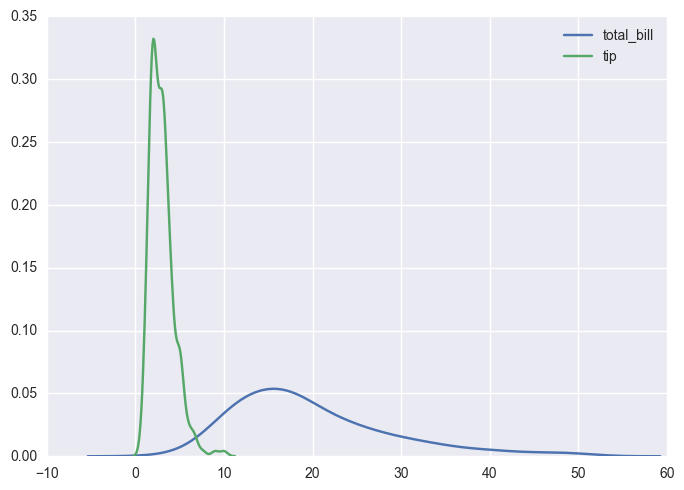

In [43]:
fig, ax = plt.subplots()
sns.kdeplot(tips.total_bill, ax=ax)
sns.kdeplot(tips.tip, ax=ax)
# ax.hist(tips.total_bill, alpha=0.3, normed=True)

## Jointplot

We now show what `jointplot` does. It draws a scatter plot of two variables and puts their histogram just outside of the scatter plot. This tells you information about not only the joint distribution, but also the marginals.

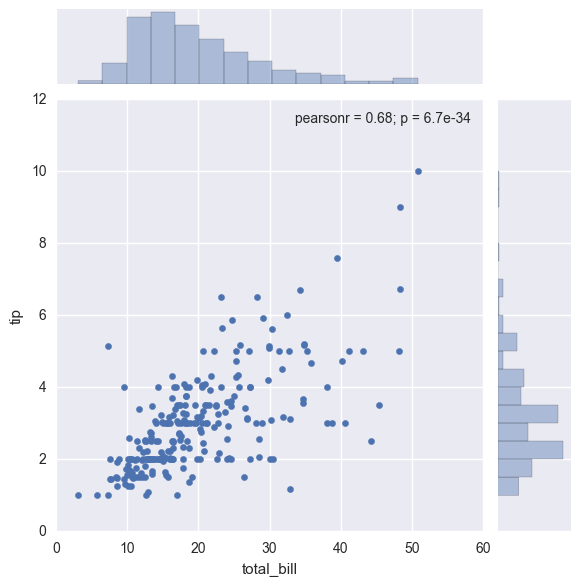

In [44]:
sns.jointplot(x="total_bill", y="tip", data=tips)

We can also plot everything as a kernel density estimate -- Notice the main plot is now a contour map.

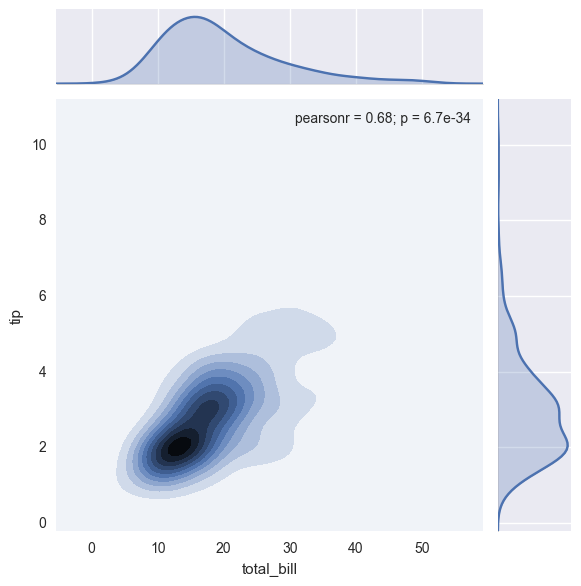

In [45]:
sns.jointplot(x="total_bill", y="tip", data=tips, kind="kde")

Like an contour map

**Exercise**: Create your own `jointplot`. Feel free to choose your own x and y data (if you can't decide then use `x=size` and `y=tip`). Interpret the output of the plot.

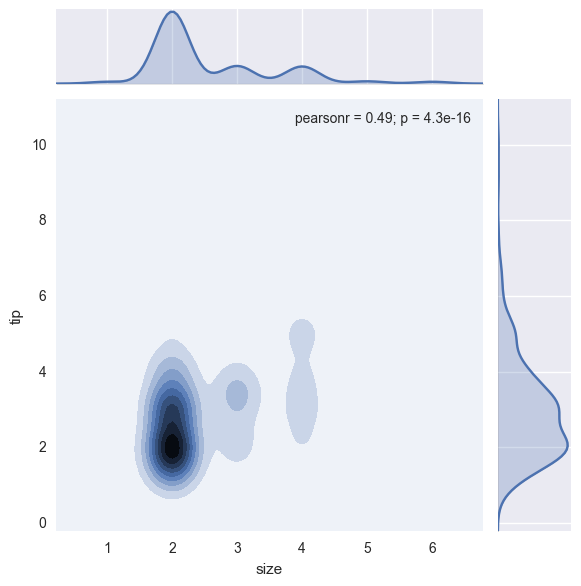

In [51]:

sns.jointplot(x="size", y="tip", data=tips, 
              kind="kde")

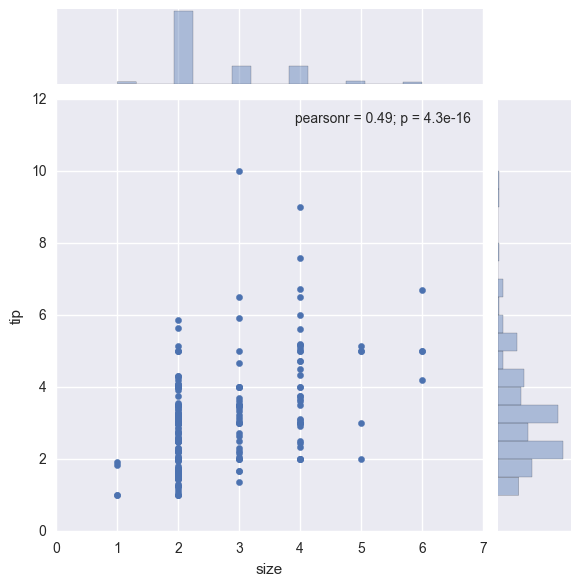

In [53]:
sns.jointplot(x="size", y="tip", data=tips)

## violinplot

Some of the story of this notebook is that distributions matter and how we can show them. Violin plots are similar to a sideways kernel density and it allows us to look at how distributions matter over some aspect of the data.

In [54]:
tita.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [55]:
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [65]:
sns.violinplot?

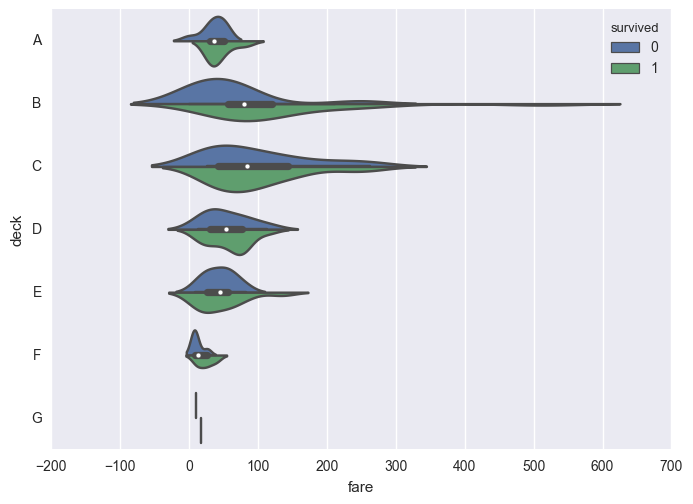

In [67]:
sns.violinplot(x="fare", y="deck", hue="survived", split=True, data=tita)
# sns.swarmplot(x="class", y="age", hue="sex", data=tita)

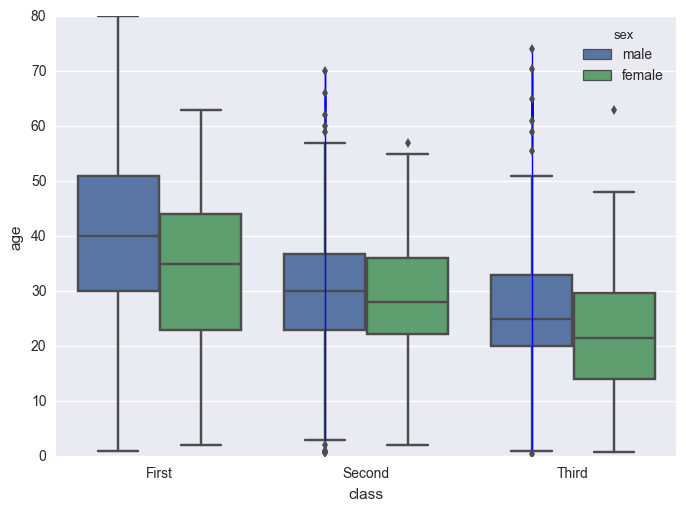

In [58]:
sns.boxplot(x="class", y="age", hue="sex", data=tita)

**Exercise**: We might also want to look at the distribution of prices across ticket classes. Make a violin plot of the prices over the different ticket classes.

In [ ]:
sns.swarmplot(x="sex", y="age", hue="survived", data=tita)

## Pairplot



Pair plots show us two things. They show us the histograms of the variables along the diagonal and then the scatter plot of each pair of variables on the off diagonal pictures.

Why might this be useful? It allows us to look get an idea of the correlations across each pair of variables and gives us an idea of their relationships across the variables.

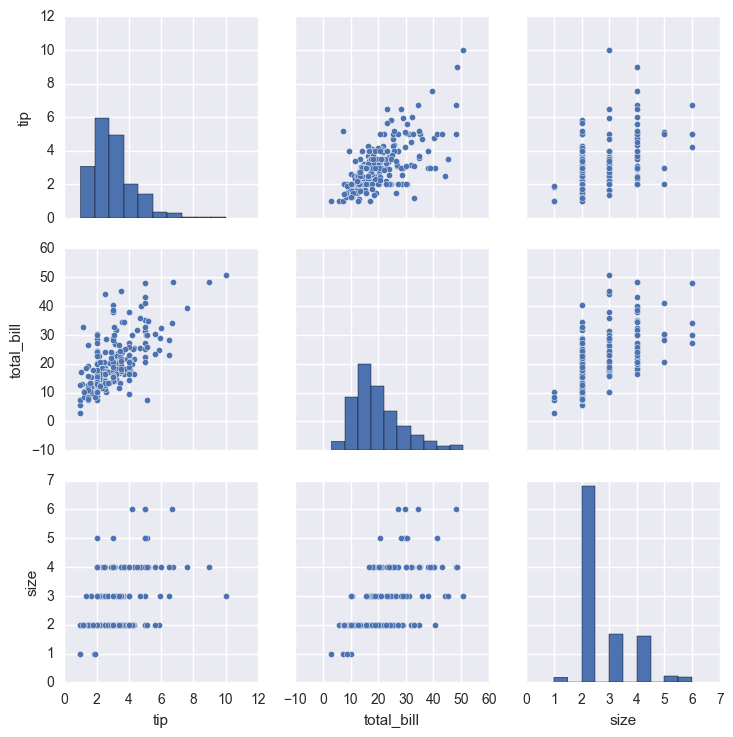

In [69]:
sns.pairplot(tips[["tip", "total_bill", "size"]], size=2.5)

Below is the same plot, but slightly different. What is different?

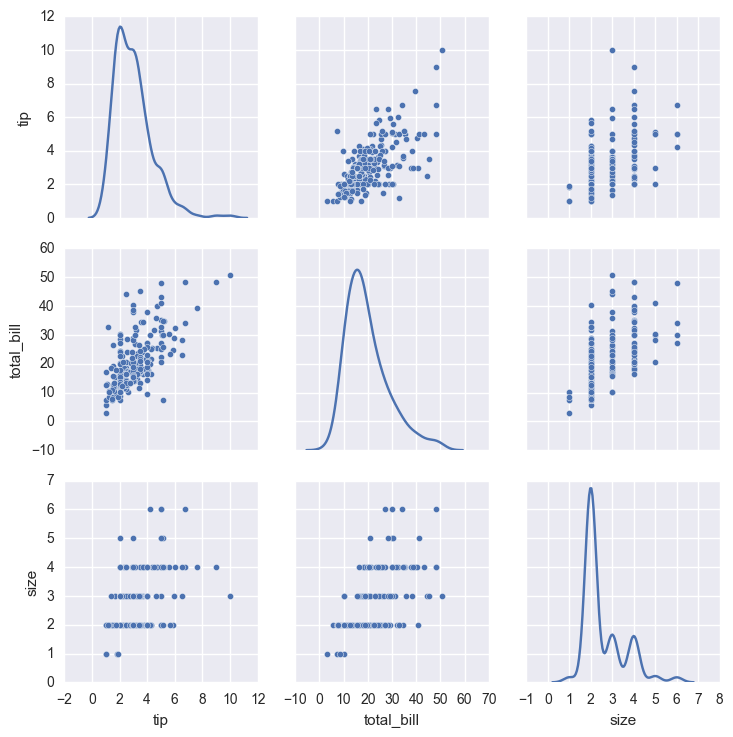

In [70]:
sns.pairplot(tips[["tip", "total_bill", "size"]], size=2.5, diag_kind="kde")

What's different about this plot?

Different colors for each company.

In [71]:
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


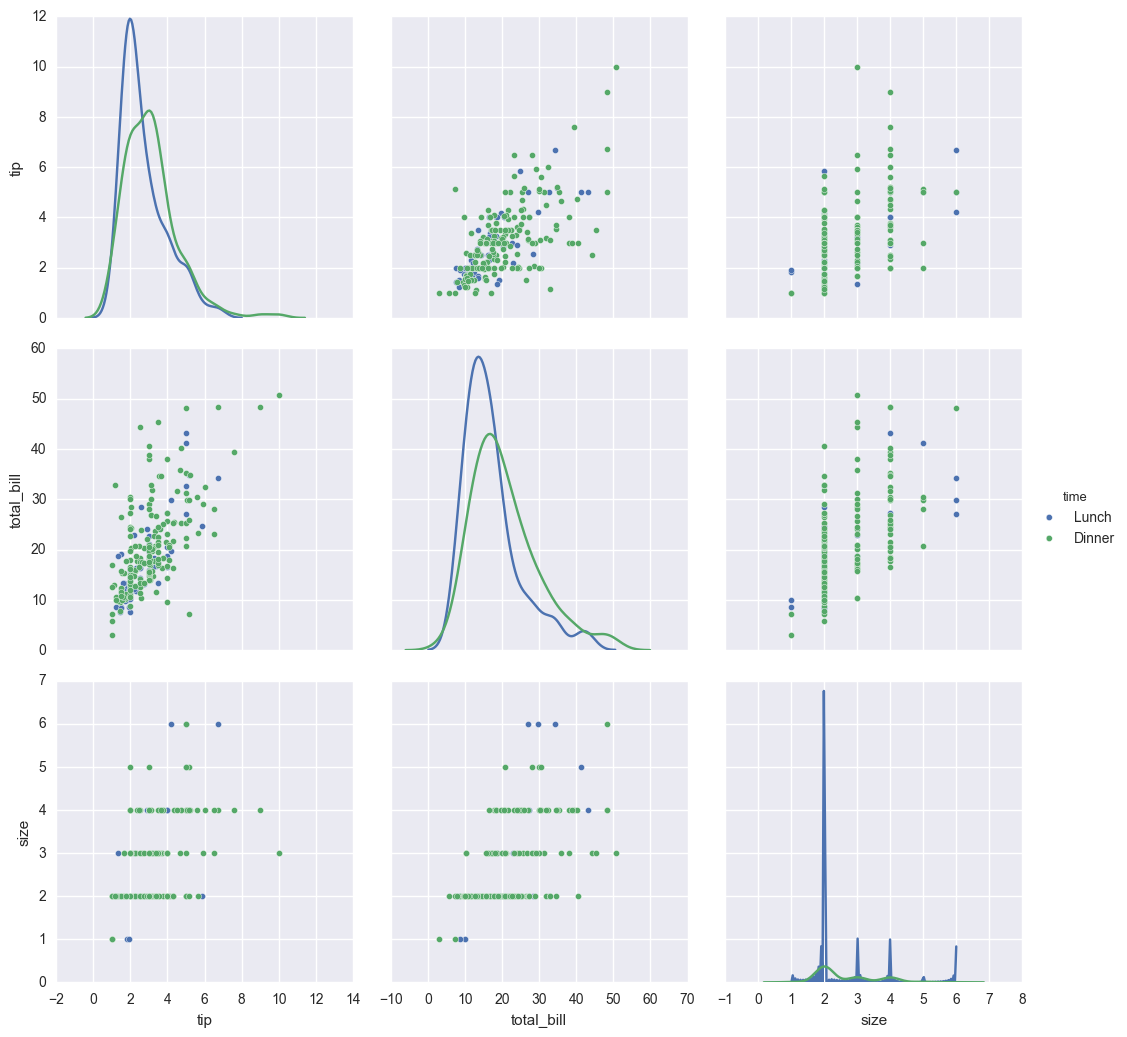

In [73]:
sns.pairplot(tips[["tip", "total_bill", "size", "time"]], size=3.5,
             hue="time", diag_kind="kde")

## lmplot

We often want to think about running regressions of variables. A statistician named Francis Anscombe came up with four datasets that:

* Same mean for $x$ and $y$
* Same variance for $x$ and $y$
* Same correlation between $x$ and $y$
* Same regression coefficient of $x$ on $y$

Below we show the scatter plot of the datasets to give you an idea of how different they are.

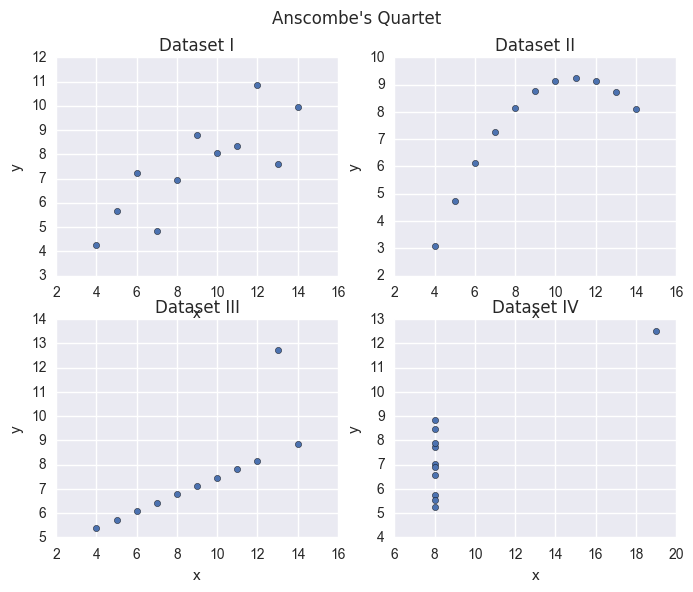

In [74]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

ansc[ansc["dataset"] == "I"].plot.scatter(x="x", y="y", ax=ax[0, 0])
ansc[ansc["dataset"] == "II"].plot.scatter(x="x", y="y", ax=ax[0, 1])
ansc[ansc["dataset"] == "III"].plot.scatter(x="x", y="y", ax=ax[1, 0])
ansc[ansc["dataset"] == "IV"].plot.scatter(x="x", y="y", ax=ax[1, 1])

ax[0, 0].set_title("Dataset I")
ax[0, 1].set_title("Dataset II")
ax[1, 0].set_title("Dataset III")
ax[1, 1].set_title("Dataset IV")

fig.suptitle("Anscombe's Quartet")

`lmplot` plots the data with the regression coefficient through it.

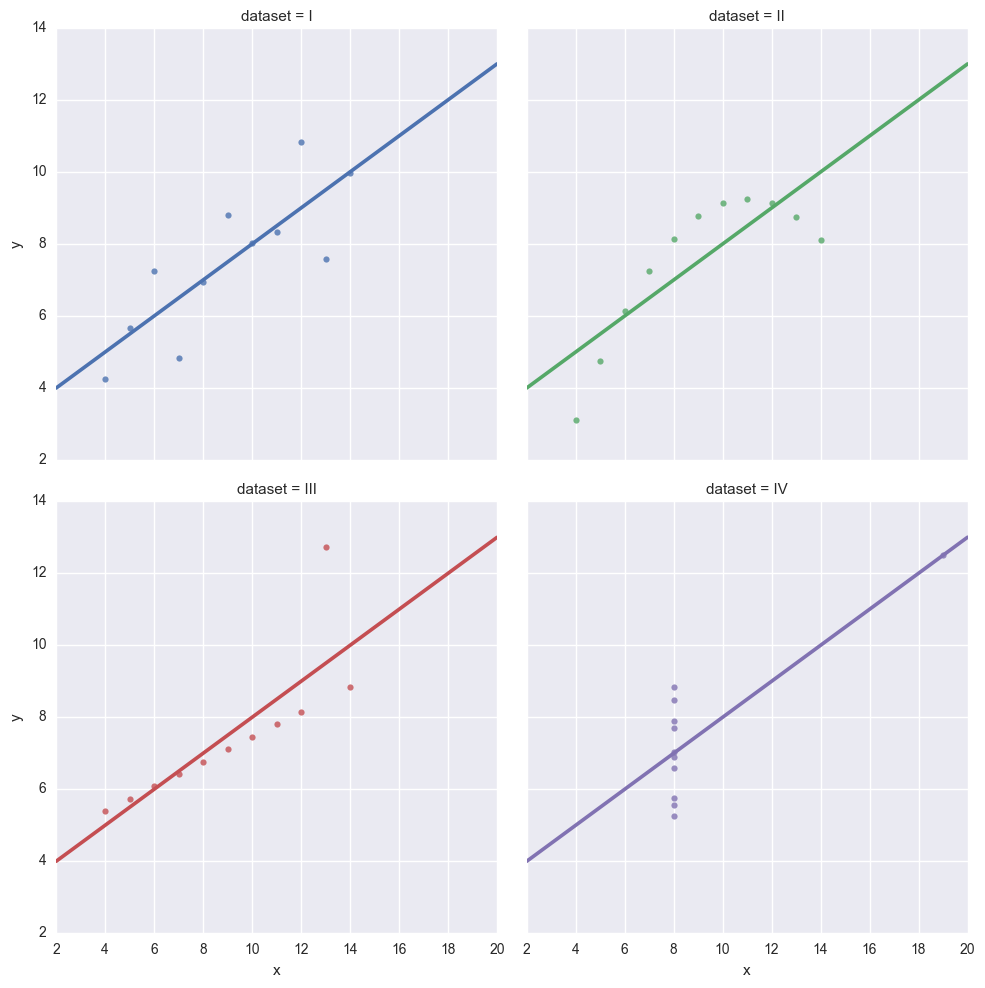

In [75]:
sns.lmplot(x="x", y="y", data=ansc, col="dataset", hue="dataset",
           col_wrap=2, ci=None)

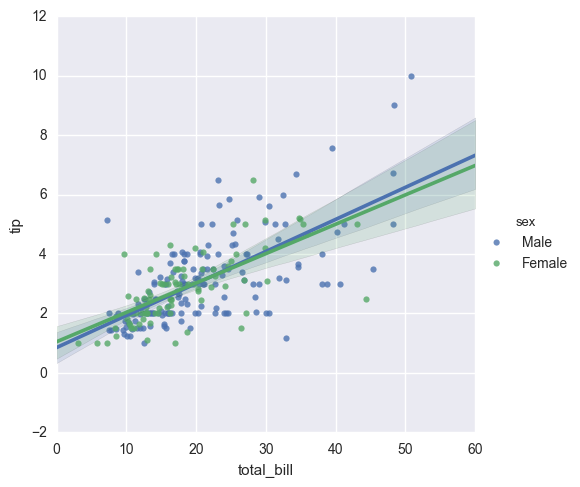

In [76]:
sns.lmplot(x="total_bill", y="tip", data=tips, hue="sex")

## regplot

`regplot` also shows the regression line through data points

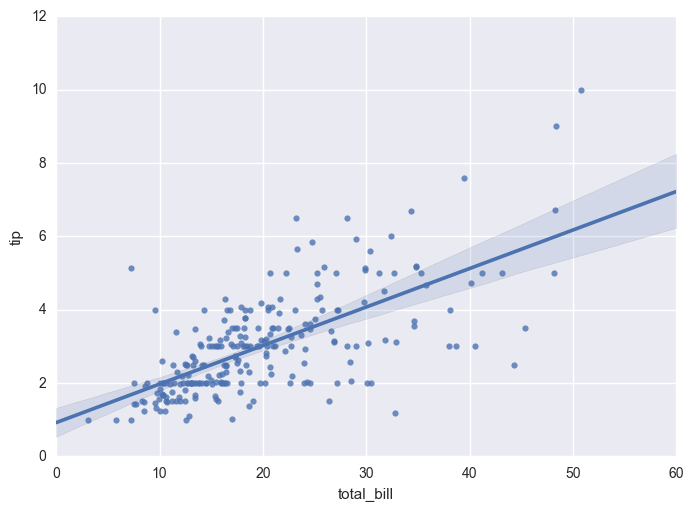

In [79]:
sns.regplot(x="total_bill", y="tip", data=tips)